# Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset = "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extract dataset

In [2]:
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/deepfake_database/validation/df/162_152.jpg  
  inflating: /content/deepfake_database/validation/df/162_156.jpg  
  inflating: /content/deepfake_database/validation/df/162_158.jpg  
  inflating: /content/deepfake_database/validation/df/162_16.jpg  
  inflating: /content/deepfake_database/validation/df/162_160.jpg  
  inflating: /content/deepfake_database/validation/df/162_164.jpg  
  inflating: /content/deepfake_database/validation/df/162_168.jpg  
  inflating: /content/deepfake_database/validation/df/162_174.jpg  
  inflating: /content/deepfake_database/validation/df/162_176.jpg  
  inflating: /content/deepfake_database/validation/df/162_18.jpg  
  inflating: /content/deepfake_database/validation/df/162_184.jpg  
  inflating: /content/deepfake_database/validation/df/162_20.jpg  
  inflating: /content/deepfake_database/validation/df/162_22.jpg  
  inflating: /content/deepfake_database/validation/df/162_26.jpg  
  

# Preprocessing

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Folder Paths

In [4]:
extracted_frames_folder = 'deepfake_database'
fake_frames = os.path.join(extracted_frames_folder, 'train_test/df/')
real_frames = os.path.join(extracted_frames_folder, 'train_test/real/')
image_format = '.jpg'
SIZE = 200

## Remove ResizedPartition.zip

In [5]:
!dir
!rm -r resized_deepfake_database
!dir

deepfake_database  drive  sample_data
rm: cannot remove 'resized_deepfake_database': No such file or directory
deepfake_database  drive  sample_data


In [6]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for f in listOfFile:
        if f.endswith(image_format):
            allFiles.append(f)
    return allFiles

'''
def preprocess(image_path):
    image = load_img(image_path)
    image = img_to_array(image)
    #image = image.flatten() / 255.0
    return image
'''

def preprocess2(image_path):
    image = cv2.imread(image_path)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((SIZE, SIZE))
    return image

## Store into Arrays

In [7]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np
from keras.utils import normalize

real_data = getListOfFiles(real_frames)
print("No. of Real Images: " + str(len(real_data)))
fake_data = getListOfFiles(fake_frames)
print("No. of Fake Images: " + str(len(fake_data)))

images = []
labels = []

for img in real_data:
    image = preprocess2(real_frames + img)
    images.append(np.array(image))
    labels.append(1)

for img in fake_data:
    image = preprocess2(fake_frames + img)
    images.append(np.array(image))
    labels.append(0)

labels = np.array(labels)
images = np.array(images)
# images = normalize(images, axis=1, order=2)
labels

No. of Real Images: 7249
No. of Fake Images: 5103


array([1, 1, 1, ..., 0, 0, 0])

## Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

#Reshape
#images = images.reshape(-1, 128, 128, 3)

#Train-Test split
images_train, images_val, labels_train, labels_val = train_test_split(images, labels, test_size=0.2, random_state=5)

#Normalization
from keras.utils import normalize
images_train = normalize(images_train, axis=1, order=2)
images_val = normalize(images_val, axis=1, order=2)

# Models

In [9]:
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras.optimizers import Adam

In [10]:
from keras.utils.vis_utils import plot_model
def plotModel(model, filename):
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True,
            rankdir='LR', expand_nested=True)

In [11]:
input_shape = (SIZE, SIZE, 3)
learning_rate = 0.001
dl_rate = 1

## MesoInception

In [12]:
def InceptionLayer(a, b, c, d):
    def func(x):
        x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)

        x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
        x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)

        x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
        x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)

        x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
        x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

        y = Concatenate(axis = -1)([x1, x2, x3, x4])

        return y
    return func

def MesoInception4(input_shape):
    x = Input(shape = input_shape)

    x1 = InceptionLayer(1, 4, 4, 2)(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

    x2 = InceptionLayer(2, 4, 4, 2)(x1)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        

    x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

    x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

    y = Flatten()(x4)
    y = Dropout(0.5)(y)
    y = Dense(16)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(1, activation = 'sigmoid')(y)

    return KerasModel(inputs = x, outputs = y), 'MesoInception4'

## Meso4

In [13]:
def Meso4(input_shape):

    model = Sequential()
    
    model.add(Conv2D(8, (3, 3), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, (5, 5), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    return model, 'Meso4'

## Compile Model

In [14]:
model, modelName = Meso4(input_shape)
optimizer = Adam(lr = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
#plotModel(model, modelName + '.png')
print(modelName)
#model.summary()

Meso4


# Training

## Begin Training

In [15]:
EPOCHS = 100
BATCH_SIZE = 10
history = model.fit(images_train, labels_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (images_val, labels_val), verbose = 1)
# model.train_on_batch(images_train, labels_train)
model.save(modelName + '.h5')

Epoch 1/100
989/989 [==============================] - 9s 10ms/step - loss: 0.1790 - accuracy: 0.7491 - val_loss: 0.2214 - val_accuracy: 0.7046
Epoch 2/100
989/989 [==============================] - 9s 9ms/step - loss: 0.1035 - accuracy: 0.8586 - val_loss: 0.3091 - val_accuracy: 0.6180
Epoch 3/100
989/989 [==============================] - 9s 9ms/step - loss: 0.0861 - accuracy: 0.8823 - val_loss: 0.2615 - val_accuracy: 0.6532
Epoch 4/100
989/989 [==============================] - 9s 9ms/step - loss: 0.0685 - accuracy: 0.9060 - val_loss: 0.1759 - val_accuracy: 0.7624
Epoch 5/100
989/989 [==============================] - 9s 9ms/step - loss: 0.0588 - accuracy: 0.9232 - val_loss: 0.1066 - val_accuracy: 0.8442
Epoch 6/100
989/989 [==============================] - 10s 10ms/step - loss: 0.0566 - accuracy: 0.9264 - val_loss: 0.1192 - val_accuracy: 0.8446
Epoch 7/100
989/989 [==============================] - 9s 9ms/step - loss: 0.0477 - accuracy: 0.9369 - val_loss: 0.0506 - val_accuracy: 0.9

## Plot Graphs

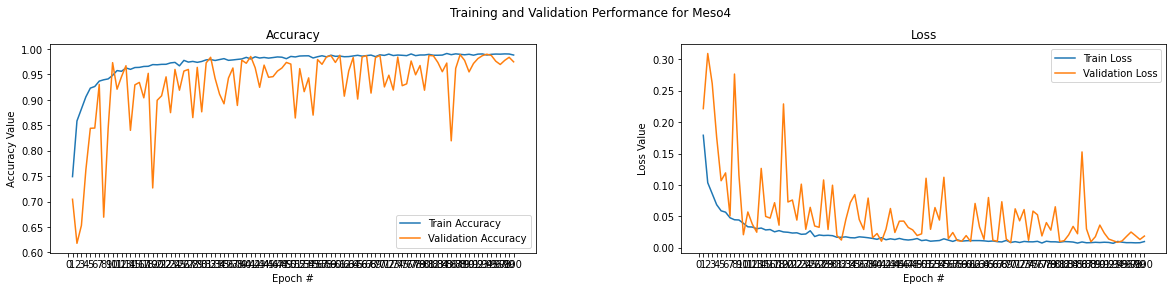

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance for ' + modelName, fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
'''
from tensorflow import keras
model = keras.models.load_model(modelName + '.h5')
'''

"\nfrom tensorflow import keras\nmodel = keras.models.load_model(modelName + '.h5')\n"

## Accuracy Score

In [18]:
_, acc = model.evaluate(images_val, labels_val)
print("Accuracy = ", (acc * 100.0), "%")

78/78 [==============================] - 1s 8ms/step - loss: 0.0186 - accuracy: 0.9749
Accuracy =  97.49089479446411 %


## Classification Report

In [19]:
from sklearn.metrics import classification_report
target_names = ['Fake', 'Real']
print(classification_report(labels_val, (model.predict(images_val) > 0.5).astype("int32"), target_names=target_names))

              precision    recall  f1-score   support

        Fake       0.95      0.99      0.97       997
        Real       0.99      0.96      0.98      1474

    accuracy                           0.97      2471
   macro avg       0.97      0.98      0.97      2471
weighted avg       0.98      0.97      0.97      2471



## Confusion Matrix

True positive =  987
False positive =  10
False negative =  52
True negative =  1422




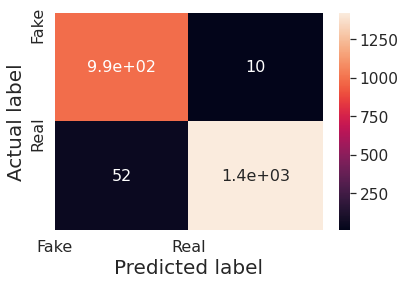

In [20]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(labels_val, (model.predict(images_val) > 0.5).astype("int32"))

## ROC Curve

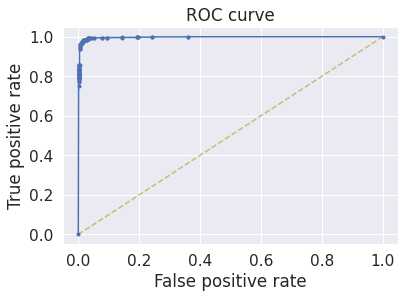

In [21]:
#Check the confusion matrix for various thresholds. Which one is good?
#Need to balance positive, negative, false positive and false negative. 
#ROC can help identify the right threshold.
##################################################################
"""
Receiver Operating Characteristic (ROC) Curve is a plot that helps us 
visualize the performance of a binary classifier when the threshold is varied. 
"""

from sklearn.metrics import roc_curve
y_preds = model.predict(images_val).ravel()

fpr, tpr, thresholds = roc_curve(labels_val, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()


In [22]:
"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn

Ideal threshold is:  60    0.190985
Name: thresholds, dtype: float32


In [23]:
#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier 
#is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.9973400527226183
